In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [20]:
csv_path = "data2_FSD/data2_FSD_patches.csv"
df = pd.read_csv(csv_path)

print(df.head())

   image_id               image_patch                mask_patch  label
0         1  patches\real\001_000.png  patches\mask\001_000.png      0
1         1  patches\real\001_001.png  patches\mask\001_001.png      0
2         1  patches\real\001_002.png  patches\mask\001_002.png      0
3         1  patches\real\001_003.png  patches\mask\001_003.png      0
4         1  patches\real\001_004.png  patches\mask\001_004.png      0


In [21]:
def hsv_skin_classifier(patch):
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)

    lower_skin = np.array([0, 59, 0], dtype=np.uint8)
    upper_skin = np.array([25, 173, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    skin_ratio = np.count_nonzero(mask) / mask.size

    return 1 if skin_ratio > 0.5 else 0

In [22]:
def ground_truth_from_mask(mask_patch):
    # mask_patch is grayscale
    skin_pixels = np.count_nonzero(mask_patch > 0)
    total_pixels = mask_patch.size

    return 1 if (skin_pixels / total_pixels) > 0.5 else 0


In [23]:
import os
DATA_ROOT = "data2_FSD"

results = []

for idx, row in df.iterrows():
    patch_path = os.path.join(DATA_ROOT, row["image_patch"])
    mask_path  = os.path.join(DATA_ROOT, row["mask_patch"])

    patch = cv2.imread(patch_path)
    mask  = cv2.imread(mask_path, 0)

    if patch is None:
        print(f"[ERROR] Cannot load patch: {patch_path}")
        continue

    if mask is None:
        print(f"[ERROR] Cannot load mask: {mask_path}")
        continue

    pred_label = hsv_skin_classifier(patch)
    gt_label   = ground_truth_from_mask(mask)

    results.append({
        "patch_id": idx,
        "pred_hsv": pred_label,
        "gt": gt_label
    })
results_df = pd.DataFrame(results)
print(results_df.head())

   patch_id  pred_hsv  gt
0         0         0   0
1         1         0   0
2         2         0   0
3         3         0   0
4         4         0   0


In [24]:
accuracy = (results_df["pred_hsv"] == results_df["gt"]).mean()
print(f"HSV Classifier Accuracy: {accuracy:.2f}")

HSV Classifier Accuracy: 0.80


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(results_df["gt"], results_df["pred_hsv"]))
print(classification_report(results_df["gt"], results_df["pred_hsv"]))

[[19083  4215]
 [ 1352  3510]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     23298
           1       0.45      0.72      0.56      4862

    accuracy                           0.80     28160
   macro avg       0.69      0.77      0.72     28160
weighted avg       0.85      0.80      0.82     28160



In [26]:
results_df.to_csv("hsv_classifier_FSD.csv", index=False)

In [46]:
skin_ref_patches = []

for idx, row in results_df.iterrows():
    if row["gt"] == 1 and row["pred_hsv"] == 1:
        patch_path = os.path.join("data4_HGR", df.loc[idx, "image_patch"])
        patch = cv2.imread(patch_path)

        if patch is not None:
            skin_ref_patches.append(patch)

print(f"Skin reference patches: {len(skin_ref_patches)}")

Skin reference patches: 3510


In [28]:
def compute_skin_hsv_model(skin_patches):
    hsv_pixels = []

    for patch in skin_patches:
        hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
        hsv_pixels.append(hsv.reshape(-1, 3))

    hsv_pixels = np.vstack(hsv_pixels)
    mean_hsv = np.mean(hsv_pixels, axis=0)

    return mean_hsv


In [29]:
skin_hsv_mean = compute_skin_hsv_model(skin_ref_patches)
print("Skin HSV mean:", skin_hsv_mean)

Skin HSV mean: [ 47.76652978 102.53861623  93.09139623]


In [30]:
conflict_indices = results_df[
    results_df["pred_hsv"] != results_df["gt"]
].index.tolist()

print(f"Conflict patches: {len(conflict_indices)}")

Conflict patches: 5567


In [31]:
def hsv_similarity_distance(patch, skin_hsv_mean):
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    patch_mean = np.mean(hsv.reshape(-1, 3), axis=0)
    dist = np.linalg.norm(patch_mean - skin_hsv_mean)
    return dist


In [32]:
similarity_results = []

for idx in conflict_indices:
    patch_path = os.path.join("data4_HGR", df.loc[idx, "image_patch"])
    patch = cv2.imread(patch_path)

    if patch is None:
        continue

    alpha = hsv_similarity_distance(patch, skin_hsv_mean)

    similarity_results.append({
        "patch_id": idx,
        "alpha_hsv": alpha
    })


In [33]:
alpha_df = pd.DataFrame(similarity_results)
print(alpha_df.head())


   patch_id  alpha_hsv
0         8  64.338514
1        23  63.617359
2        25  64.057088
3        39  63.081567
4        70  63.401860


In [34]:
alpha_df["alpha_norm"] = (
    alpha_df["alpha_hsv"] - alpha_df["alpha_hsv"].min()
) / (
    alpha_df["alpha_hsv"].max() - alpha_df["alpha_hsv"].min()
)
alpha_df["beta_hsv"] = 1 - alpha_df["alpha_norm"]

In [35]:
alpha_df["beta_hsv"] = 1 - alpha_df["alpha_norm"]

alpha_df.to_csv("hsv_similarity_metrics_FSD.csv", index=False)
np.save("skin_hsv_mean.npy", skin_hsv_mean)


In [36]:
final_hsv_df = df.copy()
final_hsv_df["label"] = results_df["pred_hsv"]

final_hsv_df = final_hsv_df[
    ["image_id", "image_patch", "mask_patch", "label"]
]



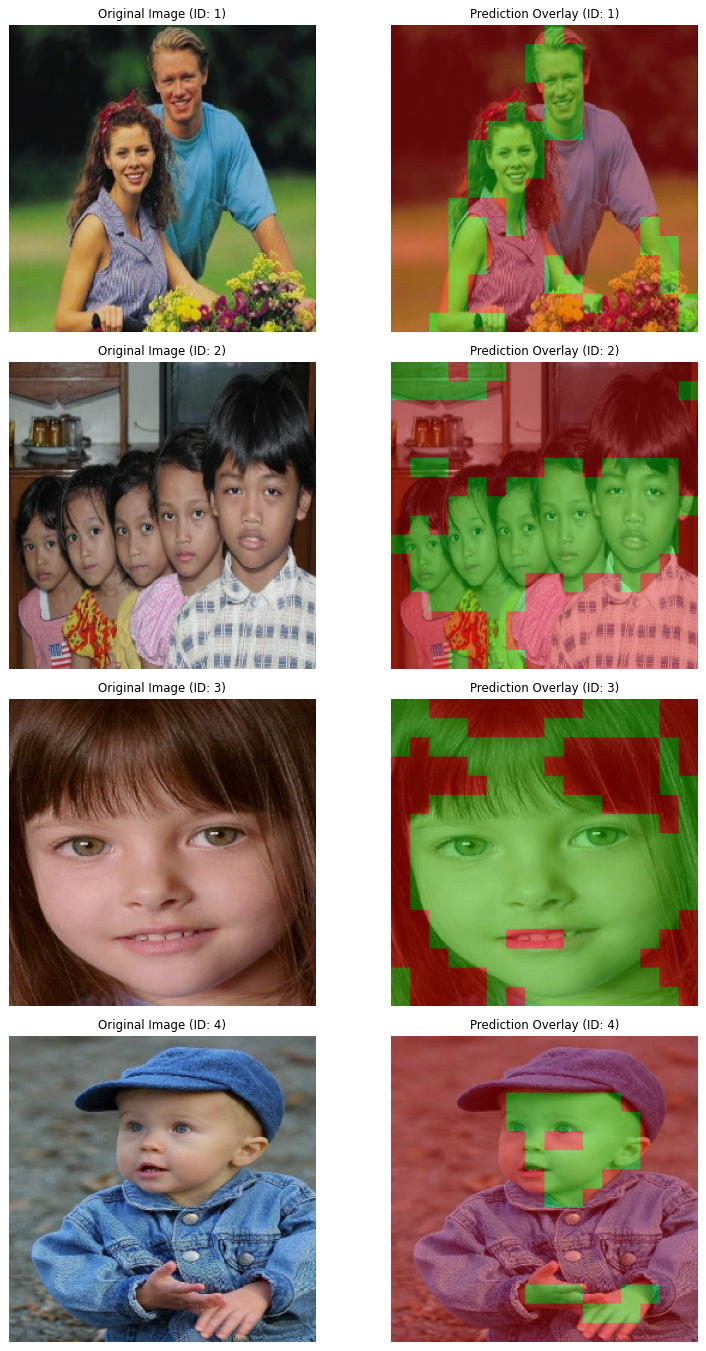

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

def visualize_multiple_full_images(df, results_df, num_images=3, data_root="data2_FSD"):
    
    unique_ids = df['image_id'].unique()[:num_images]
    
   
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images), dpi=85)
    
    
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx, target_id in enumerate(unique_ids):

        img_data = df[df['image_id'] == target_id]
        img_results = results_df.loc[img_data.index]
        
        
        num_patches = len(img_data)
        grid_cols = int(np.sqrt(num_patches)) 
        grid_rows = int(np.ceil(num_patches / grid_cols))
 
        first_patch_path = os.path.join(data_root, img_data.iloc[0]["image_patch"])
        sample_patch = cv2.imread(first_patch_path)
        if sample_patch is None: continue
        ph, pw, _ = sample_patch.shape
        
        full_img = np.zeros((grid_rows * ph, grid_cols * pw, 3), dtype=np.uint8)
        pred_mask = np.zeros((grid_rows * ph, grid_cols * pw, 3), dtype=np.uint8)

        for i, (p_idx, row) in enumerate(img_data.iterrows()):
            r_idx = i // grid_cols
            c_idx = i % grid_cols
            
            patch = cv2.imread(os.path.join(data_root, row["image_patch"]))
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            
       
            full_img[r_idx*ph:(r_idx+1)*ph, c_idx*pw:(c_idx+1)*pw] = patch
            
       
            color = [0, 255, 0] if img_results.loc[p_idx, "pred_hsv"] == 1 else [255, 0, 0]
            pred_mask[r_idx*ph:(r_idx+1)*ph, c_idx*pw:(c_idx+1)*pw] = color

 
        axes[idx, 0].imshow(full_img)
        axes[idx, 0].set_title(f"Original Image (ID: {target_id})", fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(full_img)
        axes[idx, 1].imshow(pred_mask, alpha=0.35) # Overlay with 35% opacity
        axes[idx, 1].set_title(f"Prediction Overlay (ID: {target_id})", fontsize=10)
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_multiple_full_images(df, results_df, num_images=4)